In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv("../data/adult.csv")
df = df.replace('?', np.nan).dropna()

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})

df.head()


age workclass  fnlwgt     education  education.num marital.status  \
1   82   Private  132870       HS-grad              9        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   
5   34   Private  216864       HS-grad              9       Divorced   
6   38   Private  150601          10th              6      Separated   

          occupation   relationship   race     sex  capital.gain  \
1    Exec-managerial  Not-in-family  White  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   
5      Other-service      Unmarried  White  Female             0   
6       Adm-clerical      Unmarried  White    Male             0   

   capital.loss  hours.per.week native.country  income  
1          4356              18  United-States       0  
3          3900              40  United-States       0  
4          3900              40  United-States       0  
5          3770              45  United-States       0  
6          3770              40  United-States       0

In [5]:
df_fairness = df[['sex', 'race' ]].copy()
df_fairness.head()


sex   race
1  Female  White
3  Female  White
4  Female  White
5  Female  White
6    Male  White

In [6]:
y = df['income']
X = df.drop(columns=['income'])

# one-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

X.head()


age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week  \
1   82  132870              9             0          4356              18   
3   54  140359              4             0          3900              40   
4   41  264663             10             0          3900              40   
5   34  216864              9             0          3770              45   
6   38  150601              6             0          3770              40   

   workclass_Local-gov  workclass_Private  workclass_Self-emp-inc  \
1                False               True                   False   
3                False               True                   False   
4                False               True                   False   
5                False               True                   False   
6                False               True                   False   

   workclass_Self-emp-not-inc  ...  native.country_Portugal  \
1                       False  ...                    False   
3                       False  ...                    False   
4                       False  ...                    False   
5                       False  ...                    False   
6                       False  ...                    False   

   native.country_Puerto-Rico  native.country_Scotland  native.country_South  \
1                       False                    False                 False   
3                       False                    False                 False   
4                       False                    False                 False   
5                       False                    False                 False   
6                       False                    False                 False   

   native.country_Taiwan  native.country_Thailand  \
1                  False                    False   
3                  False                    False   
4                  False                    False   
5                  False                    False   
6                  False                    False   

   native.country_Trinadad&Tobago  native.country_United-States  \
1                           False                          True   
3                           False                          True   
4                           False                          True   
5                           False                          True   
6                           False                          True   

   native.country_Vietnam  native.country_Yugoslavia  
1                   False                      False  
3                   False                      False  
4                   False                      False  
5                   False                      False  
6                   False                      False  

[5 rows x 96 columns]

In [7]:
import json

feature_list = X.columns.tolist()

with open("feature_list.json", "w") as f:
    json.dump(feature_list, f)

print("feature_list.json saved!")


feature_list.json saved!


In [8]:
from sklearn.model_selection import train_test_split

A_sex = df_fairness['sex']
A_race = df_fairness['race']

X_train, X_test, y_train, y_test, A_sex_train, A_sex_test, A_race_train, A_race_test = train_test_split(
    X, y,
    A_sex, A_race,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (24129, 96)
Test shape: (6033, 96)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8339134758826454
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4531
           1       0.71      0.56      0.63      1502

    accuracy                           0.83      6033
   macro avg       0.79      0.74      0.76      6033
weighted avg       0.83      0.83      0.83      6033



c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8571191778551301
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4531
           1       0.75      0.64      0.69      1502

    accuracy                           0.86      6033
   macro avg       0.82      0.78      0.80      6033
weighted avg       0.85      0.86      0.85      6033



In [11]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# ------------ SEX – Logistic Regression ------------
dpd_lr_sex = demographic_parity_difference(
    y_test,
    y_pred_lr,
    sensitive_features=A_sex_test
)

eod_lr_sex = equalized_odds_difference(
    y_test,
    y_pred_lr,
    sensitive_features=A_sex_test
)

print("=== Logistic Regression | SEX ===")
print("Demographic Parity Difference:", dpd_lr_sex)
print("Equal Opportunity Difference:", eod_lr_sex)

# ------------ SEX – Random Forest ------------
dpd_rf_sex = demographic_parity_difference(
    y_test,
    y_pred_rf,
    sensitive_features=A_sex_test
)

eod_rf_sex = equalized_odds_difference(
    y_test,
    y_pred_rf,
    sensitive_features=A_sex_test
)

print("\n=== Random Forest | SEX ===")
print("Demographic Parity Difference:", dpd_rf_sex)
print("Equal Opportunity Difference:", eod_rf_sex)


=== Logistic Regression | SEX ===
Demographic Parity Difference: 0.17918640995091845
Equal Opportunity Difference: 0.09244346309397565

=== Random Forest | SEX ===
Demographic Parity Difference: 0.18233927223450022
Equal Opportunity Difference: 0.09456644144144144


In [12]:
print("=== Logistic Regression | RACE ===")
dpd_lr_race = demographic_parity_difference(
    y_test,
    y_pred_lr,
    sensitive_features=A_race_test
)

eod_lr_race = equalized_odds_difference(
    y_test,
    y_pred_lr,
    sensitive_features=A_race_test
)

print("DPD:", dpd_lr_race)
print("EOD:", eod_lr_race)


print("\n=== Random Forest | RACE ===")
dpd_rf_race = demographic_parity_difference(
    y_test,
    y_pred_rf,
    sensitive_features=A_race_test
)

eod_rf_race = equalized_odds_difference(
    y_test,
    y_pred_rf,
    sensitive_features=A_race_test
)

print("DPD:", dpd_rf_race)
print("EOD:", eod_rf_race)


=== Logistic Regression | RACE ===
DPD: 0.2707854091357213
EOD: 0.4166666666666667

=== Random Forest | RACE ===
DPD: 0.22487026715356526
EOD: 0.6449487554904831


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# logistic regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# random forest
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)


c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(n_estimators=200, random_state=42)

c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\AI

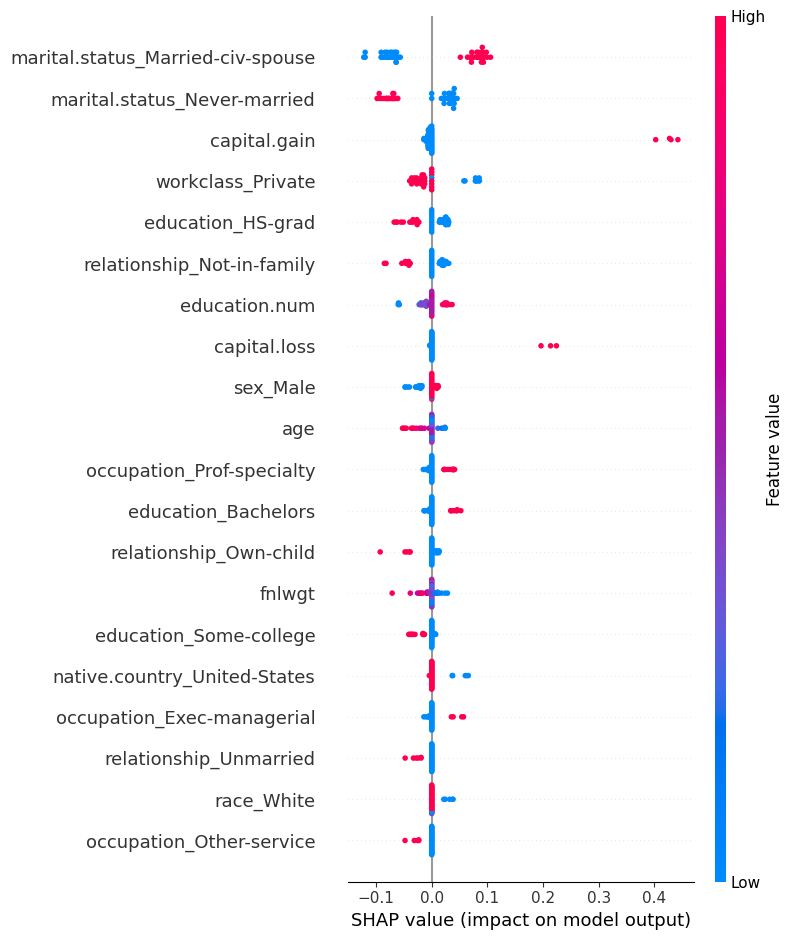

In [14]:
import shap
import numpy as np

background = X_train.sample(50, random_state=42)
X_test_small = X_test.sample(50, random_state=42)

background_np = background.values
X_test_np = X_test_small.values

# explain ONLY class 1 probability
def predict_fn(X):
    return log_reg.predict_proba(X)[:, 1]

explainer = shap.KernelExplainer(predict_fn, background_np)

shap_values = explainer.shap_values(X_test_np)

shap.summary_plot(shap_values, X_test_small, feature_names=X_test.columns)






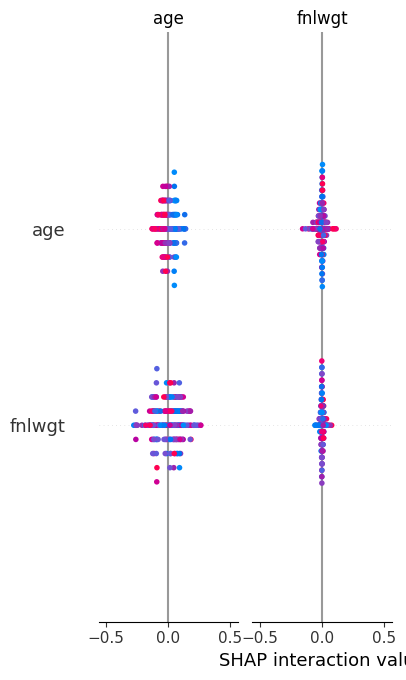

In [15]:
import shap
import numpy as np

X_test_small_rf = X_test.sample(200, random_state=42)

explainer_rf = shap.TreeExplainer(rf_clf)
shap_values_rf = explainer_rf.shap_values(X_test_small_rf)

if isinstance(shap_values_rf, list):
    shap.summary_plot(shap_values_rf[1], X_test_small_rf, feature_names=X_test.columns)
else:
    shap.summary_plot(shap_values_rf, X_test_small_rf, feature_names=X_test.columns)



In [16]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np


In [17]:
explainer = LimeTabularExplainer(
    training_data = np.array(X_train),
    feature_names = X_train.columns.tolist(),
    class_names = ['<=50K', '>50K'],
    mode = 'classification'
)


In [18]:
sample_index = 5   # any row you want
sample = X_test.iloc[sample_index].to_numpy()


In [19]:
exp = explainer.explain_instance(
    data_row = sample,
    predict_fn = log_reg.predict_proba
)


c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [20]:
exp.show_in_notebook(show_table=True)


In [21]:
exp = explainer.explain_instance(
    data_row = sample,
    predict_fn = rf_clf.predict_proba
)

exp.show_in_notebook(show_table=True)


c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
sample_index = 5   # or any row you want
sample = X_test.iloc[sample_index].to_numpy()

exp_rf = explainer.explain_instance(
    data_row = sample,
    predict_fn = rf_clf.predict_proba
)

exp_rf.show_in_notebook(show_table=True)


c:\AI-BIAS-DETECTIVE\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    demographic_parity_difference,
    equalized_odds_difference
)
import matplotlib.pyplot as plt


In [24]:
sex_test  = df_fairness.loc[X_test.index, "sex"]
race_test = df_fairness.loc[X_test.index, "race"]


In [25]:
# y_pred_lr should already exist from your LR model
metrics = {
    "selection_rate": selection_rate,          # for Demographic Parity
    "true_positive_rate": true_positive_rate   # for Equal Opportunity
}

mf_sex_lr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_lr,
    sensitive_features=sex_test
)

print("LR – by sex:\n", mf_sex_lr.by_group)


LR – by sex:
         selection_rate  true_positive_rate
sex                                       
Female        0.075687            0.513514
Male          0.254873            0.571875


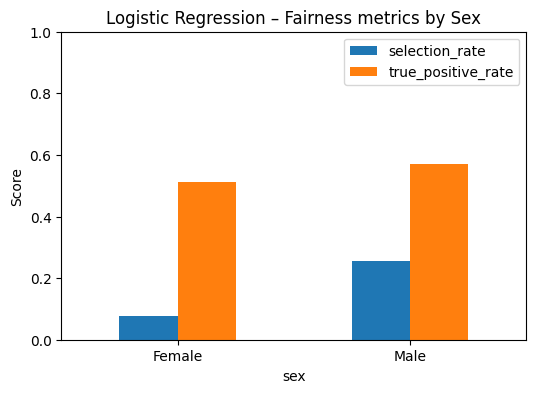

In [26]:
mf_sex_lr.by_group.plot(kind="bar", figsize=(6,4))
plt.title("Logistic Regression – Fairness metrics by Sex")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()


LR – by race:
                     selection_rate  true_positive_rate
race                                                  
Amer-Indian-Eskimo        0.159091            0.571429
Asian-Pac-Islander        0.329609            0.750000
Black                     0.095324            0.475610
Other                     0.058824            0.333333
White                     0.205651            0.562958


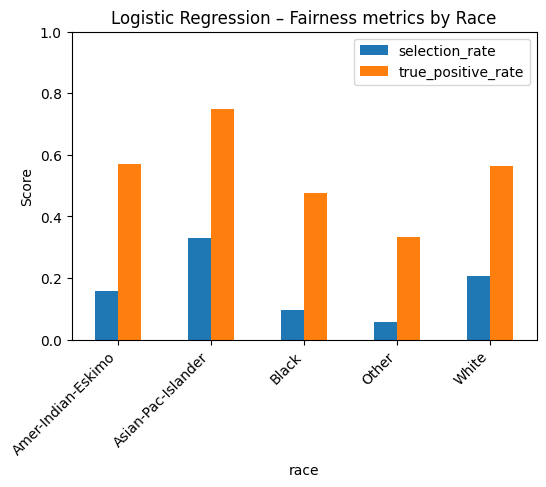

In [27]:
mf_race_lr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_lr,
    sensitive_features=race_test
)

print("LR – by race:\n", mf_race_lr.by_group)

mf_race_lr.by_group.plot(kind="bar", figsize=(6,4))
plt.title("Logistic Regression – Fairness metrics by Race")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.show()


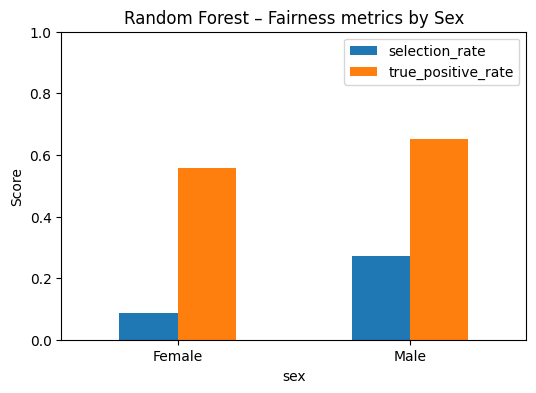

In [28]:
mf_sex_rf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_rf,
    sensitive_features=sex_test
)

mf_sex_rf.by_group.plot(kind="bar", figsize=(6,4))
plt.title("Random Forest – Fairness metrics by Sex")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


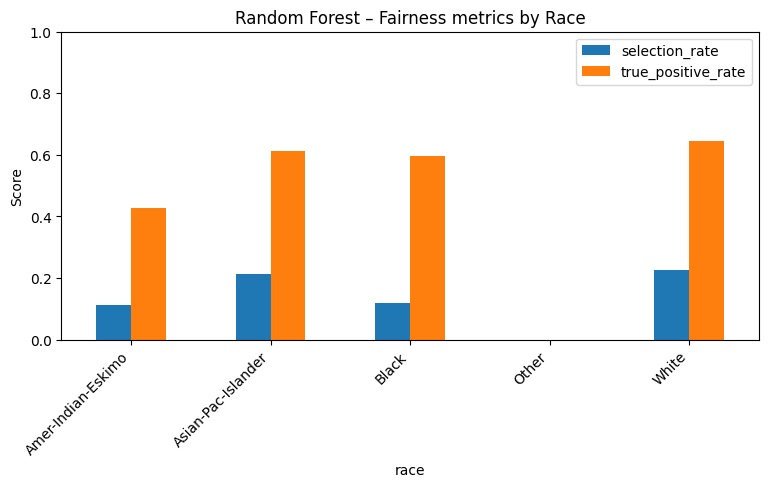

In [29]:
mf_race_rf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_rf,
    sensitive_features=race_test
)

mf_race_rf.by_group.plot(kind="bar", figsize=(9,4))
plt.title("Random Forest – Fairness metrics by Race")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()


In [30]:
import joblib

# save logistic regression
joblib.dump(log_reg, "log_reg_model.sav")

# save random forest
joblib.dump(rf_clf, "rf_clf_model.sav")

print("Models saved successfully!")


Models saved successfully!
